<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/ClasificadorBinario_inception_v3_BalanceoImblearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=550a08945499aa9ff119547dc4aefbbeec0e5dbf&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f77616c6b776974686661737461692f77616c6b776974686661737461692e6769746875622e696f2f353530613038393435343939616139666631313935343764633461656662626565633065356462662f6e62732f30325f766973696f6e2e65787465726e616c2e74696d6d2e6970796e62&logged_in=false&nwo=walkwithfastai%2Fwalkwithfastai.github.io&path=nbs%2F02_vision.external.timm.ipynb&platform=android&repository_id=295613905&repository_type=Repository&version=98

En este cuaderno probaremos la arquitectura efficientnet_b3 para ver si obtenemos unos mejores resultados.

## Efficientnet_b3 con Balanceo Sklearn

In [56]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


{'restart': True, 'status': 'ok'}

In [1]:
from fastai.vision.all import *

In [2]:
!pip install wwf
# !pip install nbdev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from wwf.utils import *
from wwf.vision.timm import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [4]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-17 08:45:51 URL:https://uca5443b4404be1a0c146fcf204b.dl.dropboxusercontent.com/cd/0/inline2/BnXF_Om94ZDCU1M7_rVrz2zASi3yIKfLHV6dyCsUKaM_fXIEFXumvTL_wgLm8zaPlBiB25XX7rJWgTlEj_3PslPi01Bc_pw09Da-TufKLapfmzEqjjkCoUpWJHZs09MYi7hGWPmXhiMp8VzVa-QhA-niwIjpmMUcOwpZUhvZDuBALGKZVrEaeM6ppL_MJSgxUpegaQCmSZ3YoCR-HIaZx8uptEpyx4NXh2XpnLUJ9Vq7UvGsDcEMHdVFeJBwl0PSwCU9thwV1XvWXmJjEYfLQ9XO3v8PmBAxRX892BhlR05pDZLOK5nxnSYZrKz01yb9LDEZZHPgOtGL1pHVOEHB10-Y0FzFuZoISSCFYSJYAXi4qr6G90LtXyPkTpiuvt9_iAagZx7Y8IaVECtibr3S4NV2aq8SrsyBi0z3mZc2zdmxoQ/file [138777773/138777773] -> "train.zip" [1]
2022-06-17 08:45:53 URL:https://uc9630502c67ad518dfd551320e7.dl.dropboxusercontent.com/cd/0/inline2/BnVkh8BhGpYJ4Sb-_Dq8NMdfhAPQrFsF42ArDLJwuPKe29pjqAYDBZ21RMNMBwdRj0HkvxfSEIjMNQtspgQm_wZ1ok3dM2tElAVOOABsFHzvMqij5amowZljcoy2pvbUuIdWCrGMPaO9dr0fseQqcaJ8nLKgSvy6l5zZBIzEGFuBQzaBpuxNo_dOO2gP053F1w9zYCl-DUVW1r_ydd7IEHIqohYDQrXdvnzbnN3yDZ8SbrP76GFSOf6Wot-8yRHH1SlTbPln4TE26CESQtbN8sE5m6q5B8eHhbH0lCAMFdPMB9orbBRGY5YEZ2rWMKE3hSA

In [ ]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [12]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [7]:
crearEstructura('dataset', ['normal', 'enfermedad'])

mkdir: cannot create directory ‘dataset’: File exists
mkdir: cannot create directory ‘dataset/test’: File exists
mkdir: cannot create directory ‘dataset/train’: File exists
mkdir: cannot create directory ‘dataset/val’: File exists
mkdir: cannot create directory ‘dataset/train/normal’: File exists
mkdir: cannot create directory ‘dataset/test/normal’: File exists
mkdir: cannot create directory ‘dataset/val/normal’: File exists
mkdir: cannot create directory ‘dataset/train/enfermedad’: File exists
mkdir: cannot create directory ‘dataset/test/enfermedad’: File exists
mkdir: cannot create directory ‘dataset/val/enfermedad’: File exists


In [8]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [9]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

#### Mover imágenes:

In [10]:
import shutil
import uuid

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.copy(pathO + '/' + str(id) + '.png', pathD + '/normal/' + str(uuid.uuid1()) + '.png')
    else:
        shutil.copy(pathO + str(id) + '.png', pathD + '/enfermedad/' + str(uuid.uuid1()) + '.png')

In [11]:
path = Path('dataset')

## Balanceo

In [13]:
y = df_train.Disease_Risk
X = df_train.drop('Disease_Risk', axis=1)

In [14]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = RandomOverSampler(sampling_strategy=0.50) #Aumentaremos hasta la mitad de lo que es la clase mayoritaria (759)
under = RandomUnderSampler(sampling_strategy=1) #clase mayoriataria
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [15]:
from collections import Counter

# evaluate pipeline
X, y = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 759, 1: 759})


In [16]:
X['Disease_Risk'] = y
df_train = X

**Una vez que tenemos el dataframe balanceado comenzamos a copiar las imágenes a las carpetas que corresponda.**

In [17]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

## Cargando el dataset

In [19]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [20]:
dls = db.dataloaders(path,bs=128)

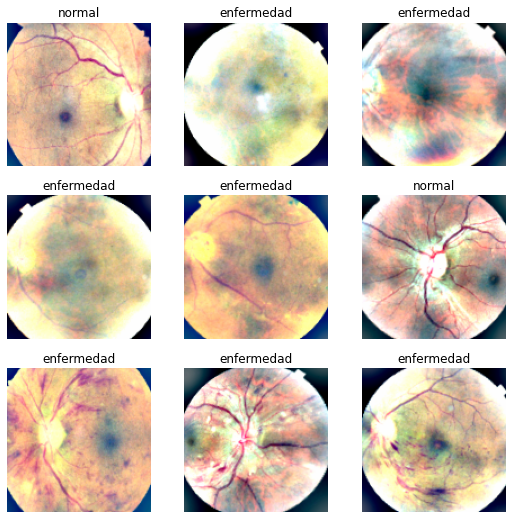

In [ ]:
dls.show_batch()

In [21]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()  
]

In [30]:
learn = timm_learner(dls, 'inception_v3', metrics=[error_rate, accuracy], cbs=callbacks)

SuggestedLRs(minimum=0.004786301031708717, steep=7.585775847473997e-07, valley=0.0006918309954926372, slide=0.0063095735386013985)

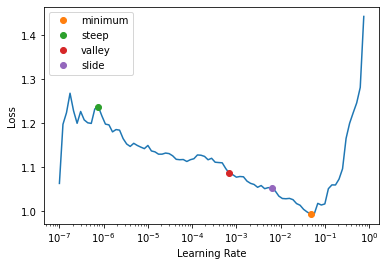

In [31]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.039083,0.652638,0.285937,0.714063,00:19


Better model found at epoch 0 with valid_loss value: 0.6526379585266113.


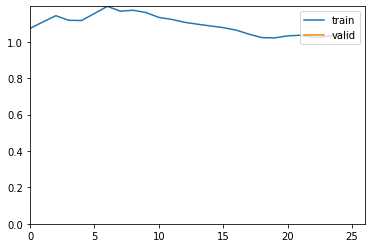

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.771597,0.699371,0.309375,0.690625,00:18
1,0.792598,0.548994,0.273438,0.726562,00:19
2,0.764155,0.603757,0.300000,0.700000,00:18
3,0.736753,0.623623,0.326562,0.673437,00:17
4,0.729813,0.511209,0.248437,0.751562,00:18
5,0.708446,0.525062,0.243750,0.756250,00:18
6,0.703505,0.537373,0.243750,0.756250,00:18
7,0.687773,0.486733,0.235938,0.764063,00:18
8,0.668150,0.592931,0.259375,0.740625,00:18
9,0.655330,0.541690,0.239063,0.760938,00:18


Better model found at epoch 0 with valid_loss value: 0.6993707418441772.


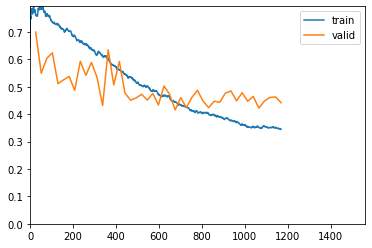

Better model found at epoch 1 with valid_loss value: 0.548994243144989.
Better model found at epoch 4 with valid_loss value: 0.5112093687057495.
Better model found at epoch 7 with valid_loss value: 0.4867327809333801.
Better model found at epoch 12 with valid_loss value: 0.43128108978271484.
Better model found at epoch 25 with valid_loss value: 0.41553425788879395.
No improvement since epoch 25: early stopping


In [32]:
learn.fine_tune(60,base_lr=1e-3)

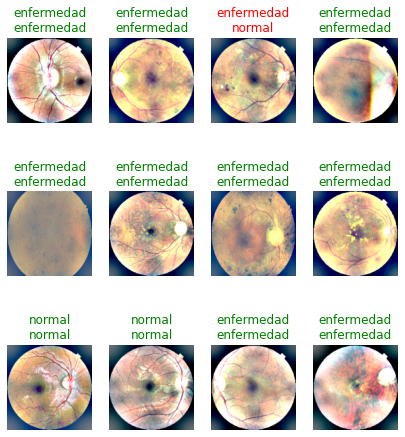

In [33]:
learn.show_results(max_n=12, figsize=(7,8))

## Evaluando el Modelo

In [26]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [27]:
learn.dls = dlsTest

Obtenemos una accuracy de 0.82.

In [28]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.17343750596046448.


(#3) [0.3829759955406189,0.17343750596046448,0.8265625238418579]

Exportamos el modelo:

In [34]:
learn.to_fp32()
learn.export('modeloBinario_inception_v3_BalanceoImblearn.pkl')